In [1]:
import numpy as np
import pandas as pd
from utils import Options
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_glass_brain
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
import nibabel as nb
import os
from glob import glob
import matplotlib.pyplot as plt

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/home/predatt/giaald/nipype/nipype/utils/misc.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterator
/home/predatt/giaald/nipype/nipype/interfaces/base/traits_extension.py:22: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.

241018-21:38:20,806 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.0-dev+gce27222


In [2]:
# folders_list = ['../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-700_nothresh/*.nii',
#                 '../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-800_nothresh/*.nii',
#                 '../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-900_nothresh/*.nii',
#                 '../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-1000_nothresh/*.nii']
folders_list = []
for m in [29]:
    for nv in [500, 600, 700, 800, 900, 1000]:
        folders_list.append(f'../../FIR_correlations/test_m{m}/ba-17-18_contr-objscrvsbas_top-{nv}_nothresh/*.nii')

exclude_participants = []#[f'sub-{s:03d}' for s in [1, 6, 12, 18, 28]]
sample_map = None
all_exp_maps = []
all_unexp_maps = []
for f in folders_list:
    these_maps = sorted(glob(f))
    these_maps = [m for m in these_maps if os.path.basename(m).split('_')[0] not in exclude_participants and 'allruns' in m]
    if sample_map is None:
        sample_map = nb.load(these_maps[0])
    exp_maps = [m for m in these_maps if 'unexp' not in m]
    unexp_maps = [m for m in these_maps if 'unexp' in m]
    exp_maps = [nb.load(m).get_fdata() for m in exp_maps]
    exp_maps = np.stack(exp_maps, axis=3)
    all_exp_maps.append(exp_maps)
    unexp_maps = [nb.load(m).get_fdata() for m in unexp_maps]
    unexp_maps = np.stack(unexp_maps, axis=3)
    all_unexp_maps.append(unexp_maps)
all_exp_maps = np.mean(np.stack(all_exp_maps, axis=4), axis=4)
all_unexp_maps = np.mean(np.stack(all_unexp_maps, axis=4), axis=4)

In [3]:
all_exp_maps.shape

(79, 95, 79, 35)

In [4]:
meanexp = np.mean(all_exp_maps, axis=3)
meanunexp = np.mean(all_unexp_maps, axis=3)
meandiff = meanexp - meanunexp
meanexp = new_img_like(sample_map, meanexp)
meanunexp = new_img_like(sample_map, meanunexp)
meandiff = new_img_like(sample_map, meandiff)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


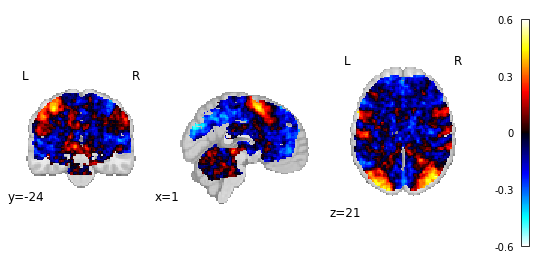

In [5]:
_ = plot_stat_map(meanexp, draw_cross=False)

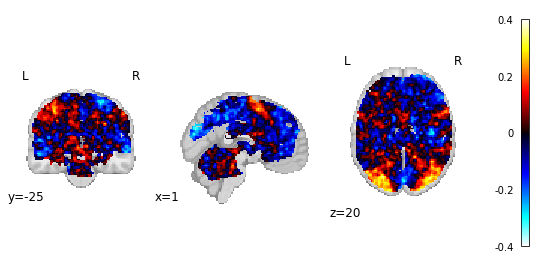

In [6]:
_ = plot_stat_map(meanunexp, draw_cross=False)

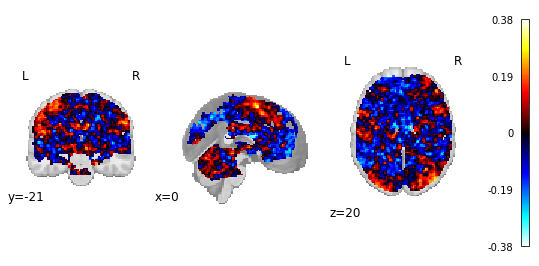

In [7]:
_ = plot_stat_map(meandiff, draw_cross=False)

In [8]:
maps_for_secondlev = np.split(exp_maps, exp_maps.shape[3], axis=3) + \
    np.split(unexp_maps, unexp_maps.shape[3], axis=3)
maps_for_secondlev = [new_img_like(sample_map, m.squeeze()) for m in maps_for_secondlev]

In [9]:
n_subjects = len(maps_for_secondlev)//2
subject = [f'sub-{i:03d}' for i in range(1, 36)]
subject = [s for s in subject if s not in exclude_participants]
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["expected vs unexpected"] + subject,
)

In [10]:
paired_design_matrix

,expected vs unexpected,sub-001,sub-002,sub-003,sub-004,sub-005,sub-006,sub-007,sub-008,sub-009,...,sub-026,sub-027,sub-028,sub-029,sub-030,sub-031,sub-032,sub-033,sub-034,sub-035
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
67,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
second_level_model_paired = SecondLevelModel().fit(
    maps_for_secondlev, design_matrix=paired_design_matrix
)

In [12]:
stat_maps_paired = second_level_model_paired.compute_contrast(
    "expected vs unexpected", output_type="all"
)

In [13]:
thresholded_map, threshold = threshold_stats_img(
    stat_maps_paired["z_score"],
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=10,
    two_sided=True,
)

In [14]:
# positive_map = thresholded_map.get_fdata()
# positive_map = new_img_like(thresholded_map, positive_map*(positive_map>0.))
# negative_map = thresholded_map.get_fdata()
# negative_map = new_img_like(thresholded_map, negative_map*(negative_map<0.))

In [15]:
# nb.save(positive_map, 'results_plots/univar_maps/infocoupling_pos.nii')
# nb.save(negative_map, 'results_plots/univar_maps/infocoupling_neg.nii')

In [16]:
threshold

3.2905267314918945

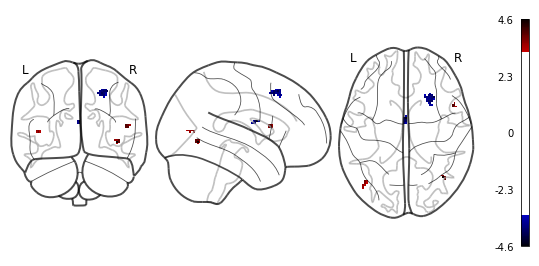

In [19]:
disp=plot_glass_brain(
    thresholded_map,
    threshold=threshold,
    colorbar=True,
    draw_cross=True,
    plot_abs=False
)
plt.savefig('results_plots/infocoupling.pdf')
#disp.add_contours('../../anat_roi_masks/glasser-v5.nii', linewidths=1.6, levels=[0.3], colors=['blue'])
# disp.add_contours('../../anat_roi_masks/glasser-MST.nii', linewidths=1.6, levels=[0.3], colors=['red'])
#disp.add_contours('../../anat_roi_masks/glasser-v5.nii', linewidths=1.6, levels=[0.3], colors=['green'])
# disp.add_contours('../../anat_roi_masks/glasser-LO2.nii', linewidths=1.6, levels=[0.3], colors=['green'])

In [18]:
get_clusters_table(stat_maps_paired['z_score'], threshold,
                   cluster_threshold=10, two_sided=True)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,40.0,-64.0,-4.0,4.559064,80
1,2,50.0,12.0,14.0,4.077323,80
2,3,-44.0,-68.0,6.0,3.841948,88
3,1,0.0,0.0,18.0,-4.469189,96
4,2,30.0,22.0,50.0,-4.102430,392
5,2a,20.0,22.0,48.0,-3.805883,


In [ ]:
ba1937_L_mask = nb.load('../../anat_roi_masks/ba-19-37_L.nii').get_fdata()
ba1937_R_mask = nb.load('../../anat_roi_masks/ba-19-37_R.nii').get_fdata()
ba4_L_mask = nb.load('../../anat_roi_masks/ba-4_L.nii').get_fdata()
ba8_R_mask = nb.load('../../anat_roi_masks/ba-8_R.nii').get_fdata()

In [ ]:
np.clip(thresholded_map.get_fdata(), 0, 1).sum()

In [ ]:
binmask = new_img_like('../../anat_roi_masks/ba-19-37.nii', np.clip(np.abs(thresholded_map.get_fdata()), 0, 1))

In [ ]:
#nb.save(binmask, '/project/3018040.07/anat_roi_masks/ba-19-37-infocoupling.nii')

In [ ]:
disp=plot_glass_brain(binmask)
disp.add_contours('../../anat_roi_masks/ba-19-37.nii', linewidths=1.6, levels=[0.3], colors=['blue'])

In [ ]:
sorted(glob('../../anat_roi_masks/*'))

In [ ]:
threshold1

In [ ]:
expmap.shape

In [ ]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-034_exp.nii', threshold=0.8)

In [ ]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-034_unexp.nii', threshold=0.7)

In [ ]:
tc = pd.read_csv('infocoupling/FIR_timecourses/sub-001_ba-17-18_contr-objscrvsbas_top-500.csv')
n_timepoints = tc.delay.nunique()
tc = tc.groupby(['delay', 'expected']).mean().reset_index()

In [ ]:
tc.testmodel.unique()

In [ ]:
opt = Options(
    sub='sub-001',
    task='test',
    model=27
)

In [ ]:
wholebrainDS = load_betas(opt, mask_templ=None, fir=True)

In [ ]:
wholebrainDS.a.voxel_dim

In [ ]:
wholebrainDS.fa.voxel_indices.shape

In [ ]:
np.max(wholebrainDS.fa.voxel_indices, axis=0)

In [ ]:
n_voxels = wholebrainDS.samples.shape[1]
wholebrainDS = split_expunexp(wholebrainDS)
nanmask = np.all(np.isfinite(wholebrainDS.samples), axis=0)
wholebrainDS = wholebrainDS[:, nanmask]

In [ ]:
wholebrainDS.samples.shape

In [ ]:
univar_df = pd.DataFrame(
        {'delay': wholebrainDS.sa.delay,
         'expected': wholebrainDS.sa.expected,
         'samples': list(wholebrainDS.samples)}
    )
univar_df = univar_df.groupby(['delay', 'expected']).mean().reset_index()

In [ ]:
# Get (n. voxels x n. timepoints) arrays for exp and unexp
exp_univar_array = np.vstack(univar_df[univar_df.expected==1].samples).T
unexp_univar_array = np.vstack(univar_df[univar_df.expected==0].samples).T
# Normalize
exp_univar_array = (exp_univar_array - np.mean(exp_univar_array, axis=1, keepdims=True))/np.std(exp_univar_array, axis=1, keepdims=True)
unexp_univar_array = (unexp_univar_array - np.mean(unexp_univar_array, axis=1, keepdims=True))/np.std(unexp_univar_array, axis=1, keepdims=True)

In [ ]:
# Same thing for multivariate sequence
exp_multivar_array = np.hstack(tc[tc.expected==True].distance).reshape(1, n_timepoints)
unexp_multivar_array = np.hstack(tc[tc.expected==False].distance).reshape(1, n_timepoints)
exp_multivar_array = (exp_multivar_array - np.mean(exp_multivar_array, axis=1, keepdims=True))/np.std(exp_multivar_array, axis=1, keepdims=True)
unexp_multivar_array = (unexp_multivar_array - np.mean(unexp_multivar_array, axis=1, keepdims=True))/np.std(unexp_multivar_array, axis=1, keepdims=True)

In [ ]:
# Compute Pearsons correlations
exp_corrs = np.dot(exp_univar_array, exp_multivar_array.T)/(n_timepoints-1)
unexp_corrs = np.dot(unexp_univar_array, unexp_multivar_array.T)/(n_timepoints-1)

In [ ]:
# Convert into brain maps
i, j, k = wholebrainDS.fa.voxel_indices.T

exp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
exp_map[i, j, k] = exp_corrs.flatten()
exp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', exp_map)

unexp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
unexp_map[i, j, k] = unexp_corrs.flatten()
unexp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', unexp_map)

In [ ]:
plot_stat_map(exp_map)

In [ ]:
plot_stat_map(unexp_map)

In [ ]:
nb.save(exp_map, 'exp_map.nii')

In [ ]:
plot_stat_map('exp_map.nii')